In [1]:
from urllib.request import urlopen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import kmeans_plusplus, KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

# Wrangling the Billboard Top 10

In [2]:
df = pd.read_csv('https://github.com/jgscott/STA380/blob/master/data/billboard.csv?raw=true')
df.head()

,Unnamed: 0,url,week_id,week_position,song,performer,song_id,instance,previous_week_position,peak_position,weeks_on_chart,year,week
0,1,http://www.billboard.com/charts/hot-100/1965-0...,7/17/1965,34,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,45.0,34,4,1965,29
1,2,http://www.billboard.com/charts/hot-100/1965-0...,7/24/1965,22,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,34.0,22,5,1965,30
2,3,http://www.billboard.com/charts/hot-100/1965-0...,7/31/1965,14,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,22.0,14,6,1965,31
3,4,http://www.billboard.com/charts/hot-100/1965-0...,8/7/1965,10,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,14.0,10,7,1965,32
4,5,http://www.billboard.com/charts/hot-100/1965-0...,8/14/1965,8,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,10.0,8,8,1965,33


In [3]:
df.describe()

,Unnamed: 0,week_position,instance,previous_week_position,peak_position,weeks_on_chart,year,week
count,327895.000000,327895.000000,327895.000000,295941.000000,327895.000000,327895.000000,327895.000000,327895.000000
mean,163948.000000,50.499309,1.072538,47.604066,41.358307,9.153793,1989.496165,26.588573
std,94655.277595,28.865707,0.334188,28.056915,29.542497,7.590281,18.145404,15.078998
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1958.000000,1.000000
25%,81974.500000,25.500000,1.000000,23.000000,14.000000,4.000000,1974.000000,14.000000
50%,163948.000000,50.000000,1.000000,47.000000,39.000000,7.000000,1989.000000,27.000000
75%,245921.500000,75.000000,1.000000,72.000000,66.000000,13.000000,2005.000000,40.000000
max,327895.000000,100.000000,10.000000,100.000000,100.000000,87.000000,2021.000000,53.000000


## Part A

In [4]:
df.groupby(['performer', 'song']).agg(count = ('week', 'count')).sort_values('count', ascending=False).head(10)

,,count
performer,song,
Imagine Dragons,Radioactive,87
AWOLNATION,Sail,79
The Weeknd,Blinding Lights,76
Jason Mraz,I'm Yours,76
LeAnn Rimes,How Do I Live,69
OneRepublic,Counting Stars,68
LMFAO Featuring Lauren Bennett & GoonRock,Party Rock Anthem,68
Jewel,Foolish Games/You Were Meant For Me,65
Adele,Rolling In The Deep,65


The table shows the top songs and their corresponding performers that are in the billboards for the most number of weeks. The top three from 1958 to 2021 include **Radioactive** by Imagine Dragons, **Sail** by AWOLNATION, and **Blinding Lights** by The Weeknd

## Part B

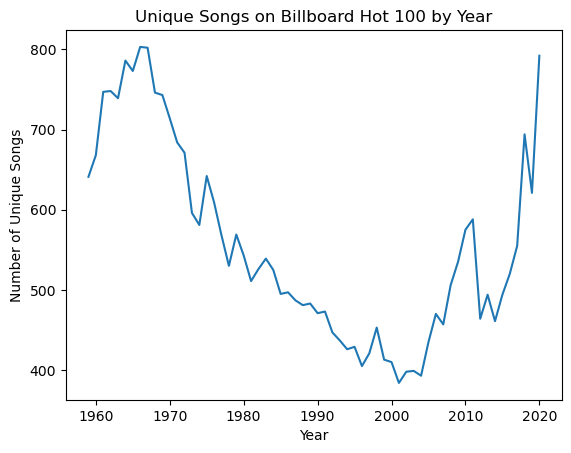

In [5]:
df_unique_songs = df[(df.year != 1958) & (df.year != 2021)].groupby('year').agg(unique_songs = ('song', 'nunique'))
sns.lineplot(data=df_unique_songs, x='year', y='unique_songs')
plt.title('Unique Songs on Billboard Hot 100 by Year')
plt.xlabel('Year')
plt.ylabel('Number of Unique Songs')
plt.show()

As shown in the plot, the number of unique songs on billboard each year peaked around 1965, dropped down to its lowest around 2004, and quickly coming back up in 2020. An interesting trend here is that the diversify of music has been decreasing and increasing in a V-shape.

## Part C

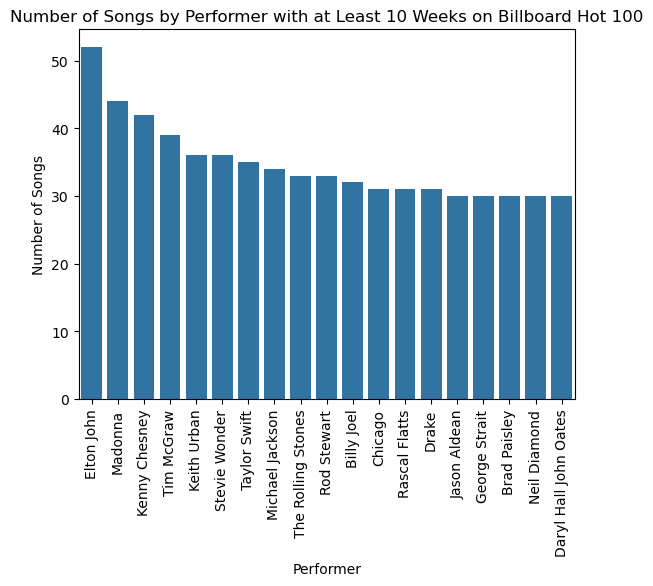

In [6]:
df_week_count = df.groupby(['performer', 'song']).agg(week_count = ('week', 'count')).reset_index()
df_song_count = df_week_count[df_week_count.week_count >= 10].groupby('performer').agg(song_count = ('song', 'count')).sort_values('song_count', ascending=False).reset_index()
sns.barplot(df_song_count[df_song_count.song_count >= 30], x = 'performer', y = 'song_count')
plt.xticks(rotation=90)
plt.title('Number of Songs by Performer with at Least 10 Weeks on Billboard Hot 100')
plt.xlabel('Performer')
plt.ylabel('Number of Songs')
plt.show()

The plot above shows the number of songs of each artist that hit billboard for at least 10 weeks. The top artist who achieved this is Elton John, accumulating over 50 songs that stayed popular for a long time.

# Visual Storytelling Part 1: Green Buildings

In [7]:
df = pd.read_csv('https://github.com/jgscott/STA380/blob/master/data/greenbuildings.csv?raw=true')
df.head()

,CS_PropertyID,cluster,size,empl_gr,Rent,leasing_rate,stories,age,renovated,class_a,...,green_rating,net,amenities,cd_total_07,hd_total07,total_dd_07,Precipitation,Gas_Costs,Electricity_Costs,cluster_rent
0,379105,1,260300,2.22,38.56,91.39,14,16,0,1,...,1,0,1,4988,58,5046,42.57,0.013700,0.029000,36.78
1,122151,1,67861,2.22,28.57,87.14,5,27,0,0,...,0,0,1,4988,58,5046,42.57,0.013731,0.029045,36.78
2,379839,1,164848,2.22,33.31,88.94,13,36,1,0,...,0,0,1,4988,58,5046,42.57,0.013731,0.029045,36.78
3,94614,1,93372,2.22,35.00,97.04,13,46,1,0,...,0,0,0,4988,58,5046,42.57,0.013731,0.029045,36.78
4,379285,1,174307,2.22,40.69,96.58,16,5,0,1,...,0,0,1,4988,58,5046,42.57,0.013731,0.029045,36.78


# Visual Storytelling Part 2: Capital Metro Data

In [8]:
df = pd.read_csv('https://github.com/jgscott/STA380/blob/master/data/capmetro_UT.csv?raw=true')
df.head()

,timestamp,boarding,alighting,day_of_week,temperature,hour_of_day,month,weekend
0,2018-09-01 06:00:00,0,1,Sat,74.82,6,Sep,weekend
1,2018-09-01 06:15:00,2,1,Sat,74.82,6,Sep,weekend
2,2018-09-01 06:30:00,3,4,Sat,74.82,6,Sep,weekend
3,2018-09-01 06:45:00,3,4,Sat,74.82,6,Sep,weekend
4,2018-09-01 07:00:00,2,4,Sat,74.39,7,Sep,weekend


In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

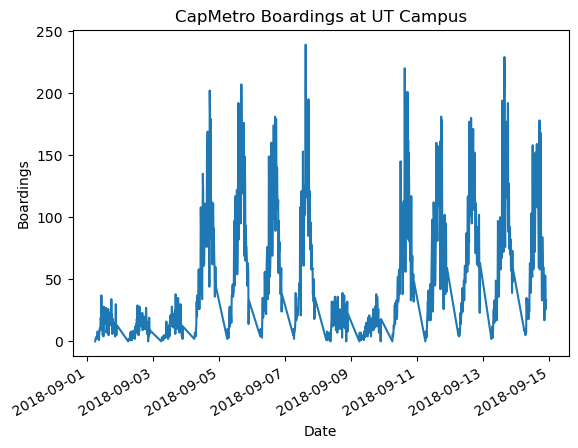

In [10]:
df[df.index < '2018-09-15']['boarding'].plot()
plt.title('CapMetro Boardings at UT Campus')
plt.xlabel('Date')
plt.ylabel('Boardings')
plt.show()

# Clustering and Dimensionality Reduction

In [118]:
df = pd.read_csv('https://github.com/jgscott/STA380/blob/master/data/wine.csv?raw=true')
df.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [119]:
df.describe()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed.acidity         6497 non-null   float64
 1   volatile.acidity      6497 non-null   float64
 2   citric.acid           6497 non-null   float64
 3   residual.sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free.sulfur.dioxide   6497 non-null   float64
 6   total.sulfur.dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


## PCA

In [140]:
scaler = StandardScaler()
pca = PCA(n_components=3, random_state=0)
tsne = TSNE(n_components=2, random_state=0)

X = df.drop(['color', 'quality'], axis=1)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
X_tsne = tsne.fit_transform(X_scaled)

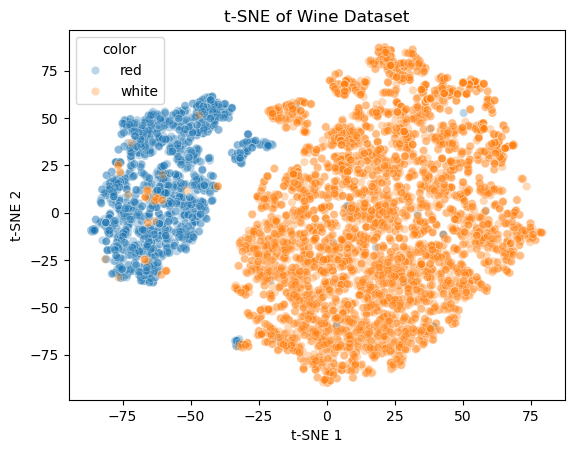

In [141]:
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['color'], alpha=0.3)
plt.title('t-SNE of Wine Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## K-means Clustering

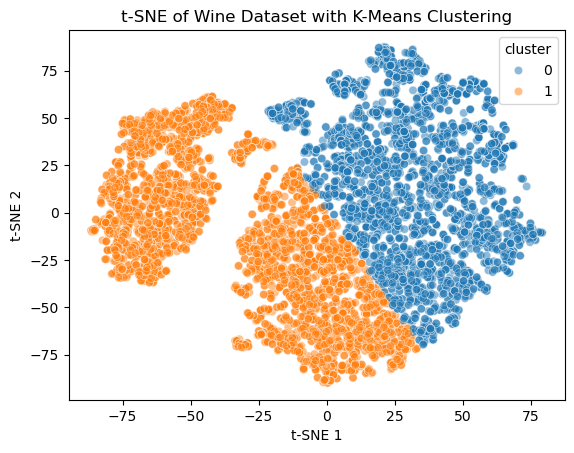

In [145]:
#kmeans with kmeans++
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0)
kmeans.fit(X_tsne)
df['cluster'] = kmeans.labels_

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['cluster'], alpha=0.5)
plt.title('t-SNE of Wine Dataset with K-Means Clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

It is obvious that KMeans isn't quite doing the job separating the two clusters.

## Hierarchical Clustering

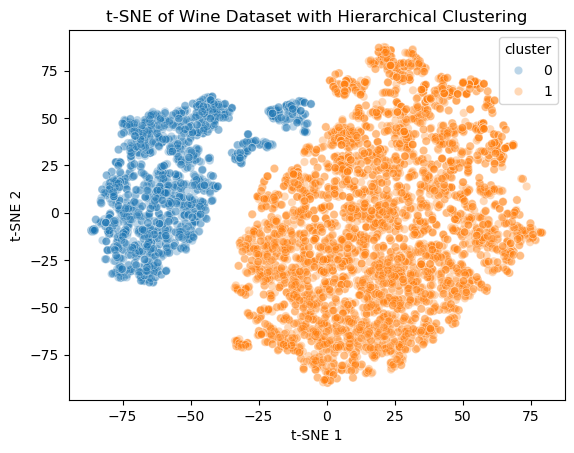

In [146]:
Z = linkage(X_tsne, method='centroid')

df['cluster'] = fcluster(Z, 2, criterion='maxclust') - 1

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['cluster'], alpha=0.3)
plt.title('t-SNE of Wine Dataset with Hierarchical Clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Hierarchical clustering with linkage of centroid, however, does seems to reasonably separate the two clusters.

In [147]:
# centroid of each cluster
df.drop('color', axis=1).groupby('cluster').mean()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,8.226821,0.516538,0.280803,2.697052,0.091969,17.272832,53.749133,0.996612,3.293017,0.641561,10.317245,5.585549
1,6.848217,0.275477,0.332362,6.439857,0.042993,35.334802,138.243445,0.994001,3.191458,0.491242,10.555149,5.902874


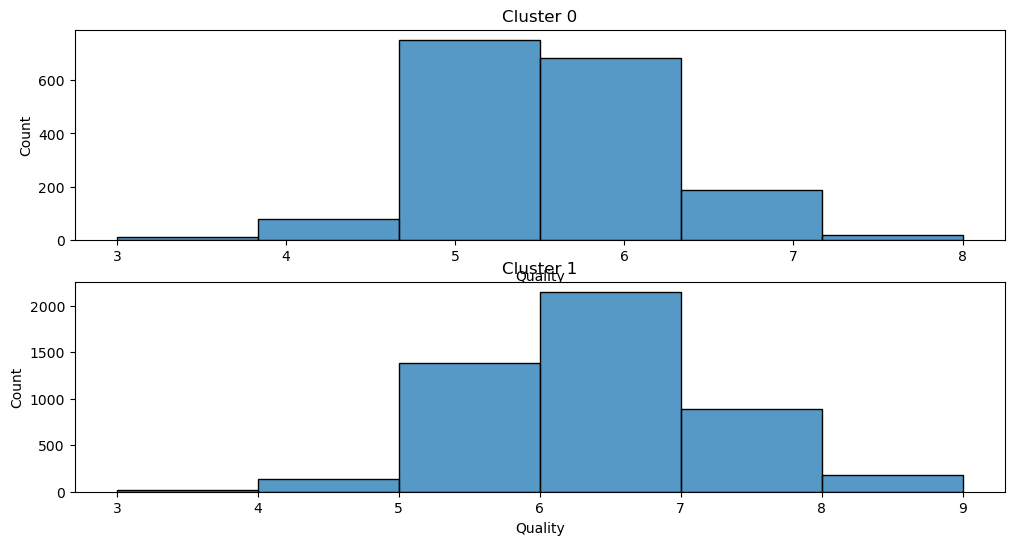

In [152]:
# compare quality of each cluster in histogram in 2 subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sns.histplot(df[df.cluster == 0]['quality'], bins=6, ax=ax[0])
ax[0].set_title('Cluster 0')
ax[0].set_xlabel('Quality')
ax[0].set_ylabel('Count')
sns.histplot(df[df.cluster == 1]['quality'], bins=6, ax=ax[1])
ax[1].set_title('Cluster 1')
ax[1].set_xlabel('Quality')
ax[1].set_ylabel('Count')
plt.show()

# Market Segmentation

In [6]:
df = pd.read_csv('https://github.com/jgscott/STA380/blob/master/data/social_marketing.csv?raw=true')
df.head()

# The Reuters Corpus

# Association Rule Mining

In [15]:
playlists = pd.read_csv('https://github.com/jgscott/STA380/blob/master/data/playlists.csv?raw=true')
groceries = urlopen('https://github.com/jgscott/STA380/blob/master/data/groceries.txt?raw=true').read().decode('utf-8')

In [27]:
groceries = groceries.split('\n')
groceries[:10]

NameError: name 'groceries' is not defined

# Image Classification with Neural Networks

In [2]:
train_data = ImageFolder(root='')
train_data

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'https://github.com/jgscott/STA380/tree/master/data/EuroSAT_RGB'